# 1. Kamlan_Filter Class

In [52]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

In [53]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

# 2. Implementing the Kalman Model

In [54]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt

import datetime
import pandas_datareader as web

In [55]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 1, 1)
df_pfe = web.DataReader('PFE', 'yahoo', start, end) 
pfe= df_pfe
pfe=pfe.reset_index()
pfe['Date'] = pd.to_datetime(pfe['Date'])
pfe['Typical_Price'] = pfe[['High','Low','Close']].mean(axis=1)
pfe['lrets'] = (np.log(pfe.Close) - np.log(pfe.Close.shift(1))) * 100.
pfe.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Typical_Price,lrets
0,2014-01-02,29.032257,28.776091,28.908918,28.899431,18366266.0,22.159529,28.902593,NaN
1,2014-01-03,29.250475,28.823528,28.833017,28.956356,15847312.0,22.203180,29.010120,0.196782
2,2014-01-06,29.364326,28.965843,29.193548,28.984819,25255421.0,22.225004,29.104996,0.098249
3,2014-01-07,29.430740,29.165085,29.278936,29.165085,23423042.0,22.363232,29.253637,0.620004
4,2014-01-08,29.402277,29.079697,29.203035,29.364326,24161053.0,22.515999,29.282100,0.680828


F:\anaconda\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


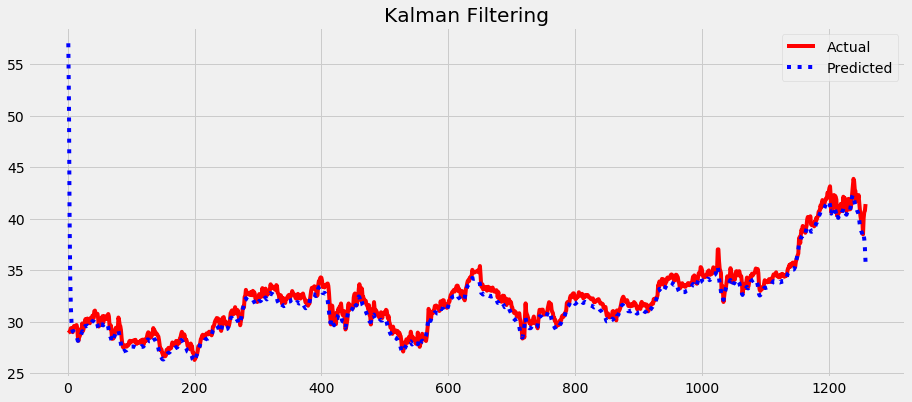

In [56]:
Y = pfe['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, y_pred,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

In [57]:
results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(y_pred),
                  'Date':pfe['Date'],
                  'Open':pfe['Open'],
                  'Close':pfe['Close']
                       })


In [58]:
results.set_index('Date',inplace = True)
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2014-01-02,28.899431,57.021315,28.908918,28.899431
2014-01-03,28.956356,51.388877,28.833017,28.956356
2014-01-06,28.984819,40.121733,29.193548,28.984819
2014-01-07,29.165085,34.305827,29.278936,29.165085
2014-01-08,29.364326,31.420641,29.203035,29.364326
2014-01-09,29.345350,29.985111,29.487665,29.345350
2014-01-10,29.117647,29.289700,29.259962,29.117647
2014-01-13,28.975332,29.037638,29.278936,28.975332
2014-01-14,29.411764,29.043243,29.013283,29.411764


# 3.1 Long Short Day trading:
* if predicted > yesterdays close, buy and sell at end of day

* if predicted < yesterdays close, sell and buy at end of day

In [59]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)-1):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open & Sell at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        # action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
        
    else:
        action.append('Sell at Open & Bull at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        # action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio,5))
    print('\n')
        

0 Buy at Open 9973.58 345 0
0 Sell at Close 9970.3 0


1 Buy at Open 9947.39 345 9
1 Sell at Close 9998.94 0


2 Buy at Open 9984.19 342 28
2 Sell at Close 9940.81 0


3 Buy at Open 9925.56 339 24
3 Sell at Close 9910.96 0


4 Buy at Open 9899.83 339 15
4 Sell at Close 9969.51 0


5 Buy at Open 9966.83 338 21
5 Sell at Close 9939.73 0


6 Sell at Open 9919.13 - 339 10
6 Buy Back at Close 9880.88 0


7 Sell at Open 9867.0 - 337 0
7 Buy Back at Close 9764.69 0


8 Buy at Open 9748.46 336 29
8 Sell at Close 9911.35 0


9 Sell at Open 9898.29 - 336 1
9 Buy Back at Close 9940.73 0


10 Sell at Open 9939.73 - 336 4
10 Buy Back at Close 9940.55 0


11 Sell at Open 9932.4 - 335 0
11 Buy Back at Close 9881.55 0


12 Sell at Open 9865.5 - 332 14
12 Buy Back at Close 9851.15 0


13 Sell at Open 9832.65 - 331 1
13 Buy Back at Close 9821.09 0


14 Sell at Open 9800.44 - 333 23
14 Buy Back at Close 9820.28 0


15 Sell at Open 9808.44 - 335 28
15 Buy Back at Close 9591.71 0


16 Sell at Open 9576.32 

177 Sell at Open 7899.53 - 278 21
177 Buy Back at Close 7946.9 0


178 Sell at Open 7934.18 - 277 28
178 Buy Back at Close 8004.23 0


179 Sell at Open 7992.0 - 277 25
179 Buy Back at Close 8061.68 0


180 Sell at Open 8054.8 - 276 14
180 Buy Back at Close 7974.53 0


181 Sell at Open 7952.58 - 277 14
181 Buy Back at Close 7945.56 0


182 Sell at Open 7924.48 - 280 19
182 Buy Back at Close 8001.92 0


183 Sell at Open 7998.86 - 280 7
183 Buy Back at Close 8058.99 0


184 Sell at Open 8057.31 - 280 9
184 Buy Back at Close 7973.33 0


185 Sell at Open 7961.67 - 280 21
185 Buy Back at Close 7916.26 0


186 Sell at Open 7910.12 - 281 7
186 Buy Back at Close 7943.78 0


187 Sell at Open 7936.78 - 281 4
187 Buy Back at Close 7887.46 0


188 Sell at Open 7885.87 - 283 5
188 Buy Back at Close 7831.8 0


189 Sell at Open 7829.49 - 283 1
189 Buy Back at Close 7803.64 0


190 Sell at Open 7781.02 - 280 13
190 Buy Back at Close 7775.43 0


191 Sell at Open 7769.12 - 279 26
191 Buy Back at Close 77

345 Sell at Open 9446.05 - 293 16
345 Buy Back at Close 9462.05 0


346 Sell at Open 9447.61 - 294 16
346 Buy Back at Close 9558.45 0


347 Sell at Open 9535.01 - 293 23
347 Buy Back at Close 9558.01 0


348 Sell at Open 9548.03 - 294 6
348 Buy Back at Close 9590.29 0


349 Sell at Open 9573.13 - 294 28
349 Buy Back at Close 9589.97 0


350 Sell at Open 9566.51 - 295 10
350 Buy Back at Close 9556.92 0


351 Sell at Open 9542.45 - 294 21
351 Buy Back at Close 9588.55 0


352 Sell at Open 9579.49 - 293 14
352 Buy Back at Close 9587.93 0


353 Sell at Open 9585.05 - 293 26
353 Buy Back at Close 9686.1 0


354 Sell at Open 9665.66 - 293 13
354 Buy Back at Close 9620.29 0


355 Sell at Open 9596.66 - 292 32
355 Buy Back at Close 9587.1 0


356 Sell at Open 9571.73 - 292 21
356 Buy Back at Close 9553.94 0


357 Sell at Open 9539.66 - 294 3
357 Buy Back at Close 9553.82 0


358 Sell at Open 9536.87 - 294 12
358 Buy Back at Close 9520.98 0


359 Sell at Open 9507.73 - 295 10
359 Buy Back at Cl

512 Buy Back at Close 7943.84 0


513 Sell at Open 7942.07 - 277 22
513 Buy Back at Close 8119.13 0


514 Sell at Open 8090.02 - 274 24
514 Buy Back at Close 8002.24 0


515 Sell at Open 7996.76 - 279 2
515 Buy Back at Close 8117.88 0


516 Sell at Open 8102.65 - 279 23
516 Buy Back at Close 8117.71 0


517 Sell at Open 8117.65 - 276 17
517 Buy Back at Close 8058.71 0


518 Sell at Open 8043.88 - 275 14
518 Buy Back at Close 7971.78 0


519 Sell at Open 7965.61 - 275 27
519 Buy Back at Close 8029.14 0


520 Sell at Open 8012.57 - 275 8
520 Buy Back at Close 7971.0 0


521 Sell at Open 7951.71 - 273 5
521 Buy Back at Close 7827.2 0


522 Sell at Open 7811.18 - 271 16
522 Buy Back at Close 7855.46 0


523 Sell at Open 7829.68 - 272 12
523 Buy Back at Close 7797.81 0


524 Sell at Open 7785.81 - 272 19
524 Buy Back at Close 7797.06 0


525 Sell at Open 7775.46 - 274 27
525 Buy Back at Close 7740.07 0


526 Sell at Open 7722.24 - 276 8
526 Buy Back at Close 7601.93 0


527 Sell at Open 759

667 Sell at Open 9003.3 - 273 8
667 Buy Back at Close 9013.89 0


668 Sell at Open 9013.66 - 273 28
668 Buy Back at Close 9046.84 0


669 Sell at Open 9016.77 - 272 19
669 Buy Back at Close 9079.65 0


670 Sell at Open 9060.65 - 272 12
670 Buy Back at Close 9013.29 0


671 Sell at Open 8996.13 - 272 32
671 Buy Back at Close 9012.65 0


672 Sell at Open 8995.53 - 273 30
672 Buy Back at Close 9012.58 0


673 Sell at Open 9008.48 - 273 6
673 Buy Back at Close 9011.89 0


674 Sell at Open 9001.29 - 272 6
674 Buy Back at Close 8978.9 0


675 Sell at Open 8960.0 - 272 20
675 Buy Back at Close 9010.97 0


676 Sell at Open 8990.35 - 273 18
676 Buy Back at Close 9010.94 0


677 Sell at Open 8981.69 - 274 16
677 Buy Back at Close 8880.71 0


678 Sell at Open 8870.97 - 275 4
678 Buy Back at Close 9044.56 0


679 Sell at Open 9018.44 - 276 1
679 Buy Back at Close 8914.7 0


680 Sell at Open 8902.28 - 275 27
680 Buy Back at Close 8882.31 0


681 Sell at Open 8874.42 - 276 7
681 Buy Back at Close 89

790 Sell at Open 7357.37 - 231 21
790 Buy Back at Close 7382.76 0


791 Sell at Open 7353.89 - 230 14
791 Buy Back at Close 7446.45 0


792 Sell at Open 7424.03 - 229 2
792 Buy Back at Close 7445.59 0


793 Sell at Open 7437.07 - 229 30
793 Buy Back at Close 7477.93 0


794 Sell at Open 7473.53 - 231 0
794 Buy Back at Close 7477.91 0


795 Sell at Open 7445.76 - 229 32
795 Buy Back at Close 7510.35 0


796 Sell at Open 7487.04 - 229 12
796 Buy Back at Close 7509.9 0


797 Sell at Open 7497.9 - 229 9
797 Buy Back at Close 7509.08 0


798 Sell at Open 7491.37 - 230 13
798 Buy Back at Close 7508.73 0


799 Sell at Open 7487.39 - 233 27
799 Buy Back at Close 7540.92 0


800 Sell at Open 7528.41 - 234 12
800 Buy Back at Close 7540.41 0


801 Sell at Open 7521.75 - 234 13
801 Buy Back at Close 7572.49 0


802 Sell at Open 7547.08 - 233 32
802 Buy Back at Close 7572.45 0


803 Sell at Open 7547.08 - 233 32
803 Buy Back at Close 7572.45 0


804 Sell at Open 7552.83 - 234 7
804 Buy Back at Clos

926 Sell at Open 7956.02 - 247 9
926 Buy Back at Close 7974.4 0


927 Sell at Open 7944.82 - 246 9
927 Buy Back at Close 7942.15 0


928 Buy at Open 7923.81 246 15
928 Sell at Close 7973.82 0


929 Buy at Open 7956.49 246 28
929 Sell at Close 8038.17 0


930 Buy at Open 8024.17 246 17
930 Sell at Close 8272.24 0


931 Sell at Open 8263.02 - 247 22
931 Buy Back at Close 8238.15 0


932 Sell at Open 8213.8 - 247 0
932 Buy Back at Close 8373.16 0


933 Sell at Open 8342.69 - 247 19
933 Buy Back at Close 8305.45 0


934 Sell at Open 8291.14 - 247 8
934 Buy Back at Close 8338.98 0


935 Sell at Open 8322.92 - 246 31
935 Buy Back at Close 8304.91 0


936 Sell at Open 8283.67 - 243 7
936 Buy Back at Close 8304.5 0


937 Sell at Open 8279.43 - 242 11
937 Buy Back at Close 8269.77 0


938 Sell at Open 8254.36 - 241 13
938 Buy Back at Close 8235.35 0


939 Sell at Open 8208.63 - 241 14
939 Buy Back at Close 8133.46 0


940 Sell at Open 8119.46 - 241 28
940 Buy Back at Close 8099.44 0


941 Sell 

1062 Sell at Open 8272.54 - 242 28
1062 Buy Back at Close 8201.81 0


1063 Sell at Open 8182.23 - 243 21
1063 Buy Back at Close 7972.68 0


1064 Buy at Open 7953.7 240 27
1064 Sell at Close 8005.75 0


1065 Sell at Open 7977.25 - 239 0
1065 Buy Back at Close 7938.7 0


1066 Sell at Open 7910.49 - 237 1
1066 Buy Back at Close 7938.48 0


1067 Sell at Open 7919.55 - 235 25
1067 Buy Back at Close 7937.86 0


1068 Sell at Open 7930.85 - 236 23
1068 Buy Back at Close 7871.01 0


1069 Buy at Open 7861.44 236 17
1069 Sell at Close 8006.07 0


1070 Sell at Open 7975.48 - 238 19
1070 Buy Back at Close 8177.39 0


1071 Sell at Open 8156.04 - 241 7
1071 Buy Back at Close 8176.76 0


1072 Sell at Open 8164.63 - 242 1
1072 Buy Back at Close 8076.09 0


1073 Buy at Open 8071.44 241 1
1073 Sell at Close 8109.03 0


1074 Buy at Open 8094.88 237 25
1074 Sell at Close 8108.63 0


1075 Sell at Open 8101.96 - 239 27
1075 Buy Back at Close 8142.57 0


1076 Sell at Open 8135.81 - 238 10
1076 Buy Back at Clo

1192 Sell at Open 10606.45 - 255 33
1192 Buy Back at Close 10600.74 0


1193 Sell at Open 10594.35 - 255 21
1193 Buy Back at Close 10641.97 0


1194 Sell at Open 10628.23 - 255 21
1194 Buy Back at Close 10683.1 0


1195 Sell at Open 10652.42 - 255 14
1195 Buy Back at Close 10724.48 0


1196 Sell at Open 10695.97 - 255 26
1196 Buy Back at Close 10724.39 0


1197 Sell at Open 10712.9 - 255 10
1197 Buy Back at Close 10851.13 0


1198 Sell at Open 10815.64 - 256 36
1198 Buy Back at Close 10892.93 0


1199 Sell at Open 10859.35 - 256 27
1199 Buy Back at Close 10934.93 0


1200 Sell at Open 10911.53 - 257 23
1200 Buy Back at Close 11063.76 0


1201 Sell at Open 11055.42 - 259 19
1201 Buy Back at Close 11192.37 0


1202 Sell at Open 11168.45 - 259 1
1202 Buy Back at Close 10938.47 0


1203 Sell at Open 10900.61 - 259 12
1203 Buy Back at Close 10531.73 0


1204 Buy at Open 10509.9 259 22
1204 Sell at Close 10780.08 0


1205 Sell at Open 10767.55 - 260 20
1205 Buy Back at Close 10656.81 0


120

In [60]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':pfe.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': pfe.Date[1:],
                                 'Action':  action,
                                 # 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Portfolio($),Amount($)
1,28.956356,51.388877,2014-01-03,Buy at Open & Sell at Close,0,9970.303774
2,28.984819,40.121733,2014-01-06,Buy at Open & Sell at Close,0,9998.942837
3,29.165085,34.305827,2014-01-07,Buy at Open & Sell at Close,0,9940.808239
4,29.364326,31.420641,2014-01-08,Buy at Open & Sell at Close,0,9910.963760
5,29.345350,29.985111,2014-01-09,Buy at Open & Sell at Close,0,9969.506676


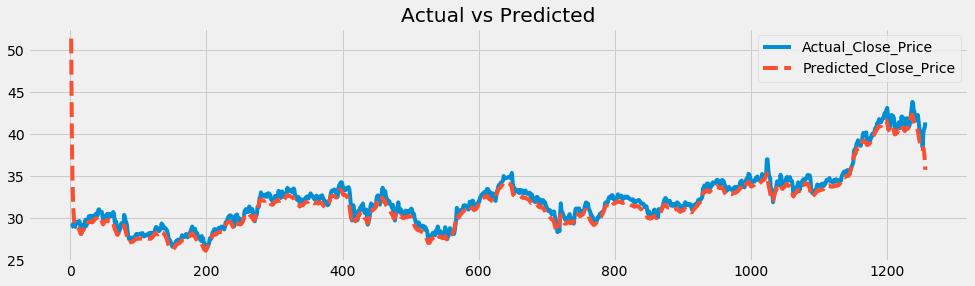

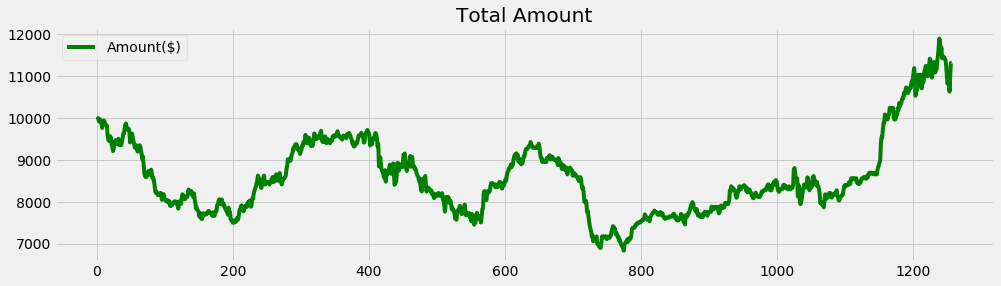

In [61]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [62]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 11315.246913909912 $
Profit_Percent: 113.15246913909914 %


* Sharpe Ratio

In [63]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [64]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0001485773556332363 0.009777242704349032


0.4500243623839631

# 3.2 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [65]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['Actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['Actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 28.899431228637695 Action: Buy Portfolio: 9999.2 Stocks: 346 Balance_init: 0 total($) 9999.2


Stock: 28.956356048583984 Action: Bought--Holding Portfolio: 10018.9 Stocks: 346 Balance_init: 0 total($) 10018.9


Stock: 28.984819412231445 Action: Bought--Holding Portfolio: 10028.75 Stocks: 346 Balance_init: 0 total($) 10028.75


Stock: 29.165084838867188 Action: Bought--Holding Portfolio: 10091.12 Stocks: 346 Balance_init: 0 total($) 10091.12


Stock: 29.36432647705078 Action: Bought--Holding Portfolio: 10160.06 Stocks: 346 Balance_init: 0 total($) 10160.06


Stock: 29.34535026550293 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10153.49


Stock: 29.117647171020508 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10153.49


Stock: 28.975332260131836 Action: Buy Portfolio: 10141.37 Stocks: 350 Balance_init: 12 total($) 10153.37


Stock: 29.41176414489746 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10306.12


Stoc

Stock: 29.33586311340332 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 29.136621475219727 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 29.17457389831543 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 30.398481369018555 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 30.132827758789062 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 29.677419662475586 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 29.554079055786133 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 29.17457389831543 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.4

Stock: 27.675521850585938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 27.314990997314453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 27.87476348876953 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 27.504743576049805 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 27.637571334838867 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 27.011384963989258 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 27.00189781188965 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 26.745731353759766 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12605.87


Stock: 26.

Stock: 33.10246658325195 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 33.14041519165039 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 33.54838562011719 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 33.46299743652344 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.81783676147461 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.713470458984375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.533206939697266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.191650390625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.333965

Stock: 31.745731353759766 Action: Buy Portfolio: 21872.81 Stocks: 689 Balance_init: 9 total($) 21881.81


Stock: 31.622390747070312 Action: Bought--Holding Portfolio: 21787.83 Stocks: 689 Balance_init: 9 total($) 21796.83


Stock: 32.305503845214844 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22267.49


Stock: 32.40986633300781 Action: Buy Portfolio: 22265.58 Stocks: 687 Balance_init: 1 total($) 22266.58


Stock: 33.19734191894531 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22807.57


Stock: 33.6337776184082 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22807.57


Stock: 32.98861312866211 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22807.57


Stock: 32.08728790283203 Action: Buy Portfolio: 22781.97 Stocks: 710 Balance_init: 25 total($) 22806.97


Stock: 33.263755798339844 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23642.27


Stock: 33.178367614746094 A

Stock: 27.979127883911133 Action: Buy Portfolio: 25265.15 Stocks: 903 Balance_init: 7 total($) 25272.15


Stock: 28.510435104370117 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 28.425046920776367 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 28.48197364807129 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 29.022769927978516 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 28.68121337890625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 28.149904251098633 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 28.50094985961914 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25751.92


Stock: 28.44402313232422 Action: Price-Prediction-Alrea

Stock: 33.007591247558594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.96963882446289 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.466793060302734 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.73244857788086 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.96963882446289 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.703983306884766 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.81783676147461 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 31836.29


Stock: 32.2296028137207 Action: Buy Portfolio: 31810.62 Stocks: 987 Balance_init: 25 total($) 31835.62


Stock: 32.06830978393555 Action

Stock: 31.888046264648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 31.43263816833496 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 31.37571144104004 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 31.081594467163086 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 30.986717224121094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 30.834915161132812 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 31.015180587768555 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 30.929790496826172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 30.

Stock: 32.66603469848633 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.561668395996094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.618595123291016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.49525451660156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.703983306884766 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.533206939697266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.25806427001953 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.4288444519043 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.409

Stock: 31.51802635192871 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.64136505126953 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.698291778564453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.47058868408203 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.51802635192871 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.574953079223633 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.717267990112305 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.546489715576172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 40079.41


Stock: 31.65

Stock: 34.411766052246094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 34.30739974975586 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.90891647338867 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.776092529296875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.34914779663086 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.263755798339844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.45351028442383 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.64326477050781 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.728

Stock: 32.40986633300781 Action: Bought--Holding Portfolio: 45633.09 Stocks: 1408 Balance_init: 8 total($) 45641.09


Stock: 32.88425064086914 Action: Bought--Holding Portfolio: 46301.02 Stocks: 1408 Balance_init: 8 total($) 46309.02


Stock: 33.149906158447266 Action: Bought--Holding Portfolio: 46675.07 Stocks: 1408 Balance_init: 8 total($) 46683.07


Stock: 33.3870964050293 Action: Bought--Holding Portfolio: 47009.03 Stocks: 1408 Balance_init: 8 total($) 47017.03


Stock: 33.880455017089844 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 47711.68


Stock: 34.402278900146484 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 47711.68


Stock: 34.16508483886719 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 47711.68


Stock: 33.927894592285156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 47711.68


Stock: 33.90891647338867 Action: Buy Portfolio: 47709.85 St

Stock: 34.051231384277344 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 33.851993560791016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 33.870967864990234 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.20303726196289 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.08918380737305 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.39278793334961 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.582542419433594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.573055267333984 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.5



Stock: 43.178367614746094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 43.861480712890625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 43.6337776184082 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 42.82732391357422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 42.67552185058594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 41.669830322265625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 42.12523651123047 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 41.755218505859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 64502.83


Stock: 41.8

In [66]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':pfe.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': pfe.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,28.956356,51.388877,2014-01-03,Buy,346,9999.20321,9999.0
2,28.984819,40.121733,2014-01-06,Bought--Holding,346,10018.89919,10019.0
3,29.165085,34.305827,2014-01-07,Bought--Holding,346,10028.74752,10029.0
4,29.364326,31.420641,2014-01-08,Bought--Holding,346,10091.11935,10091.0
5,29.345350,29.985111,2014-01-09,Bought--Holding,346,10160.05696,10160.0


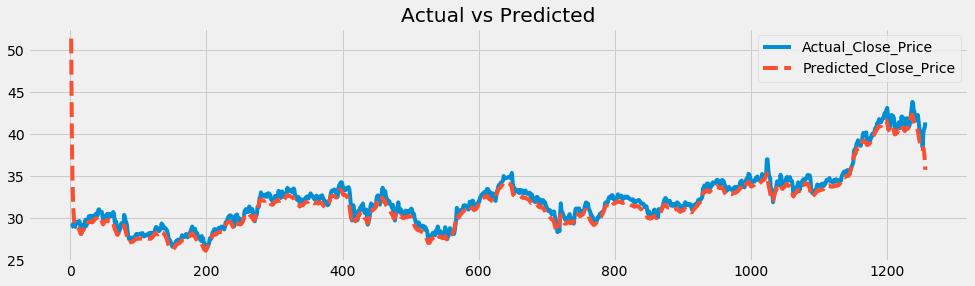

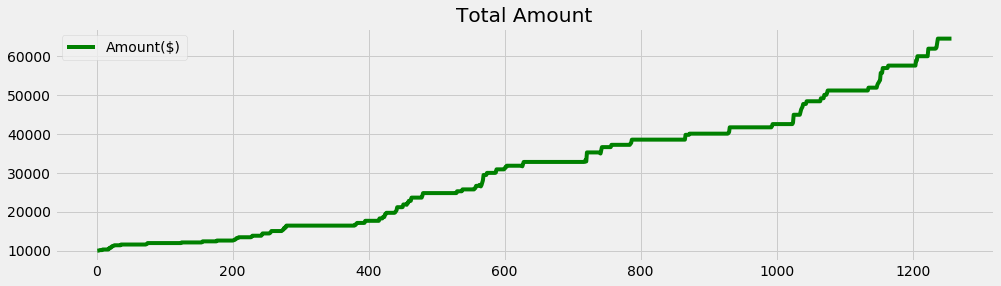

In [67]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [68]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 64503.0 $
Profit_Percent: 645.0300000000001 %


* Sharpe Ratio

In [69]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [70]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0015024346547387701 0.00590639674582592


7.533083353077236

# 3.3 Buy & Hold Trading Strategy with bollinger bands

In [71]:
long_MA = results['Actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [72]:
short_MA  = results['Actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [73]:
long_std= results['Actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [74]:

long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [75]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

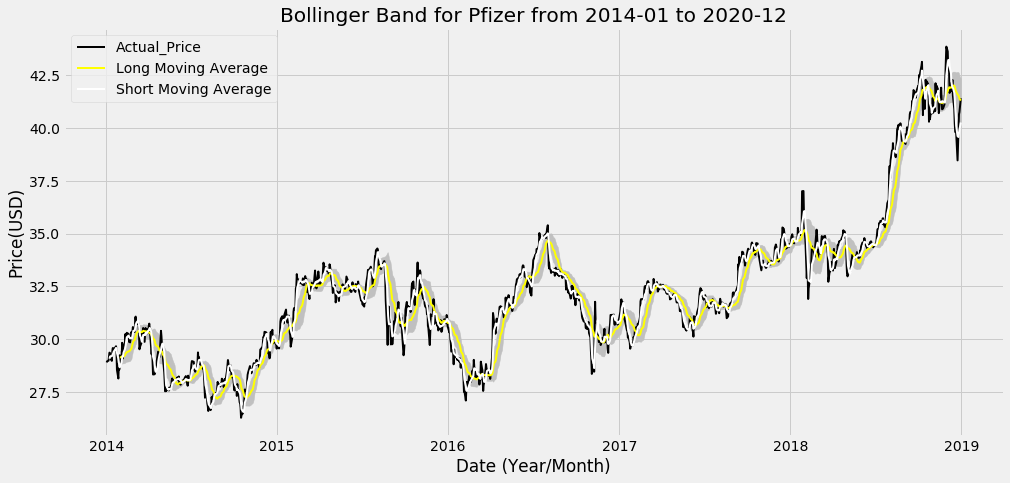

In [76]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='silver')
ax.plot(x_axis, results['Actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='white', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Pfizer from 2014-01 to 2020-12')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

In [77]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i] > results['Long_Lower_Band'][i]:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i] < results['Long_Moving_Avg'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Do nothing')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')
    

Stock: 28.899431228637695 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 28.956356048583984 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 28.984819412231445 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.165084838867188 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.36432647705078 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.34535026550293 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.117647171020508 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 28.975332260131836 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.41176414489746 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.582542419433594 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1

Stock: 27.362428665161133 Action: Buy Portfolio: 11163.87 Stocks: 408 Balance_init: 25 total($) 11188.87


Stock: 27.457305908203125 Action: Bought--Holding Portfolio: 11202.58 Stocks: 408 Balance_init: 25 total($) 11227.58


Stock: 27.409866333007812 Action: Bought--Holding Portfolio: 11183.23 Stocks: 408 Balance_init: 25 total($) 11208.23


Stock: 27.343454360961914 Action: Bought--Holding Portfolio: 11156.13 Stocks: 408 Balance_init: 25 total($) 11181.13


Stock: 27.438329696655273 Action: Bought--Holding Portfolio: 11194.84 Stocks: 408 Balance_init: 25 total($) 11219.84


Stock: 27.428842544555664 Action: Bought--Holding Portfolio: 11190.97 Stocks: 408 Balance_init: 25 total($) 11215.97


Stock: 27.713472366333008 Action: Bought--Holding Portfolio: 11307.1 Stocks: 408 Balance_init: 25 total($) 11332.1


Stock: 27.979127883911133 Action: Bought--Holding Portfolio: 11415.48 Stocks: 408 Balance_init: 25 total($) 11440.48


Stock: 27.87476348876953 Action: Bought--Holding Portfolio: 11

Stock: 30.351043701171875 Action: Bought--Holding Portfolio: 13142.0 Stocks: 433 Balance_init: 8 total($) 13150.0


Stock: 30.332067489624023 Action: Bought--Holding Portfolio: 13133.79 Stocks: 433 Balance_init: 8 total($) 13141.79


Stock: 30.313093185424805 Action: Bought--Holding Portfolio: 13125.57 Stocks: 433 Balance_init: 8 total($) 13133.57


Stock: 30.227703094482422 Action: Bought--Holding Portfolio: 13088.6 Stocks: 433 Balance_init: 8 total($) 13096.6


Stock: 30.02846336364746 Action: Bought--Holding Portfolio: 13002.32 Stocks: 433 Balance_init: 8 total($) 13010.32


Stock: 29.36432647705078 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12722.75


Stock: 29.2789363861084 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12722.75


Stock: 29.09867286682129 Action: Buy Portfolio: 12716.12 Stocks: 437 Balance_init: 6 total($) 12722.12


Stock: 29.525617599487305 Action: Bought--Holding Portfolio: 12902.69 Stocks: 437 Balance_i

Stock: 33.20683288574219 Action: Bought--Holding Portfolio: 14876.66 Stocks: 448 Balance_init: 13 total($) 14889.66


Stock: 33.007591247558594 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14800.4


Stock: 32.5711555480957 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14800.4


Stock: 32.618595123291016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14800.4


Stock: 32.713470458984375 Action: Buy Portfolio: 14786.49 Stocks: 452 Balance_init: 13 total($) 14799.49


Stock: 32.7703971862793 Action: Bought--Holding Portfolio: 14812.22 Stocks: 452 Balance_init: 13 total($) 14825.22


Stock: 32.86527633666992 Action: Bought--Holding Portfolio: 14855.1 Stocks: 452 Balance_init: 13 total($) 14868.1


Stock: 33.235294342041016 Action: Bought--Holding Portfolio: 15022.35 Stocks: 452 Balance_init: 13 total($) 15035.35


Stock: 33.62428665161133 Action: Bought--Holding Portfolio: 15198.18 Stocks: 452 B

Stock: 33.43453598022461 Action: Bought--Holding Portfolio: 15747.67 Stocks: 471 Balance_init: 24 total($) 15771.67


Stock: 33.339656829833984 Action: Bought--Holding Portfolio: 15702.98 Stocks: 471 Balance_init: 24 total($) 15726.98


Stock: 33.092979431152344 Action: Bought--Holding Portfolio: 15586.79 Stocks: 471 Balance_init: 24 total($) 15610.79


Stock: 32.99810028076172 Action: Bought--Holding Portfolio: 15542.11 Stocks: 471 Balance_init: 24 total($) 15566.11


Stock: 32.50474548339844 Action: Bought--Holding Portfolio: 15309.74 Stocks: 471 Balance_init: 24 total($) 15333.74


Stock: 32.58064651489258 Action: Bought--Holding Portfolio: 15345.48 Stocks: 471 Balance_init: 24 total($) 15369.48


Stock: 33.53889846801758 Action: Bought--Holding Portfolio: 15796.82 Stocks: 471 Balance_init: 24 total($) 15820.82


Stock: 33.927894592285156 Action: Bought--Holding Portfolio: 15980.04 Stocks: 471 Balance_init: 24 total($) 16004.04


Stock: 33.89942932128906 Action: Bought--Holding Port

Stock: 32.4003791809082 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 32.191650390625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.925996780395508 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 32.05882263183594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 32.01138687133789 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.679317474365234 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.565465927124023 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.461101531982422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.18595


Stock: 31.489564895629883 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18991.04


Stock: 31.669828414916992 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18991.04


Stock: 31.33776092529297 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18991.04


Stock: 31.47058868408203 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18991.04


Stock: 31.669828414916992 Action: Buy Portfolio: 18970.23 Stocks: 599 Balance_init: 20 total($) 18990.23


Stock: 32.01138687133789 Action: Bought--Holding Portfolio: 19174.82 Stocks: 599 Balance_init: 20 total($) 19194.82


Stock: 31.944971084594727 Action: Bought--Holding Portfolio: 19135.04 Stocks: 599 Balance_init: 20 total($) 19155.04


Stock: 32.35293960571289 Action: Bought--Holding Portfolio: 19379.41 Stocks: 599 Balance_init: 20 total($) 19399.41


Stock: 32.59013366699219 Action: Bought--Ho

Stock: 31.9165096282959 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 32.09677505493164 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 32.24857711791992 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 31.612903594970703 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 32.13472366333008 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 31.954458236694336 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 31.99241065979004 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 32.16318893432617 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21070.72


Stock: 31.92599

Stock: 32.58064651489258 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.438331604003906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.362430572509766 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.35293960571289 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.296016693115234 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.191650390625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.18216323852539 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.14421463012695 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 32.2580642700195

Stock: 31.9165096282959 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.603416442871094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.574953079223633 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.736242294311523 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.707780838012695 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.546489715576172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.603416442871094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.669828414916992 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25913.82


Stock: 31.

Stock: 34.35483932495117 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29045.71


Stock: 34.468692779541016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29045.71


Stock: 34.50664138793945 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29045.71


Stock: 34.36432647705078 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29045.71


Stock: 34.573055267333984 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29045.71


Stock: 34.8292236328125 Action: Buy Portfolio: 29012.74 Stocks: 833 Balance_init: 32 total($) 29044.74


Stock: 34.90512466430664 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29107.97


Stock: 34.97153854370117 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29107.97


Stock: 34.582542419433594 Action: Price-Prediction-Already

Stock: 39.051231384277344 Action: Bought--Holding Portfolio: 34911.8 Stocks: 894 Balance_init: 33 total($) 34944.8


Stock: 39.29791259765625 Action: Bought--Holding Portfolio: 35132.33 Stocks: 894 Balance_init: 33 total($) 35165.33


Stock: 39.93358612060547 Action: Bought--Holding Portfolio: 35700.63 Stocks: 894 Balance_init: 33 total($) 35733.63


Stock: 40.16128921508789 Action: Bought--Holding Portfolio: 35904.19 Stocks: 894 Balance_init: 33 total($) 35937.19


Stock: 40.0 Action: Bought--Holding Portfolio: 35760.0 Stocks: 894 Balance_init: 33 total($) 35793.0


Stock: 39.91461181640625 Action: Bought--Holding Portfolio: 35683.66 Stocks: 894 Balance_init: 33 total($) 35716.66


Stock: 40.0379524230957 Action: Bought--Holding Portfolio: 35793.93 Stocks: 894 Balance_init: 33 total($) 35826.93


Stock: 40.22770309448242 Action: Bought--Holding Portfolio: 35963.57 Stocks: 894 Balance_init: 33 total($) 35996.57


Stock: 39.44971466064453 Action: Bought--Holding Portfolio: 35268.04 Stoc

In [78]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':pfe.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': pfe.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,28.956356,51.388877,2014-01-03,Do nothing,0,0.0,10000.0
2,28.984819,40.121733,2014-01-06,Do nothing,0,0.0,10000.0
3,29.165085,34.305827,2014-01-07,Do nothing,0,0.0,10000.0
4,29.364326,31.420641,2014-01-08,Do nothing,0,0.0,10000.0
5,29.345350,29.985111,2014-01-09,Do nothing,0,0.0,10000.0


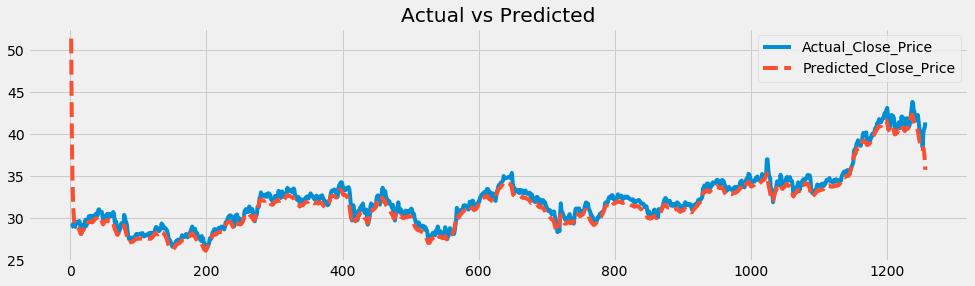

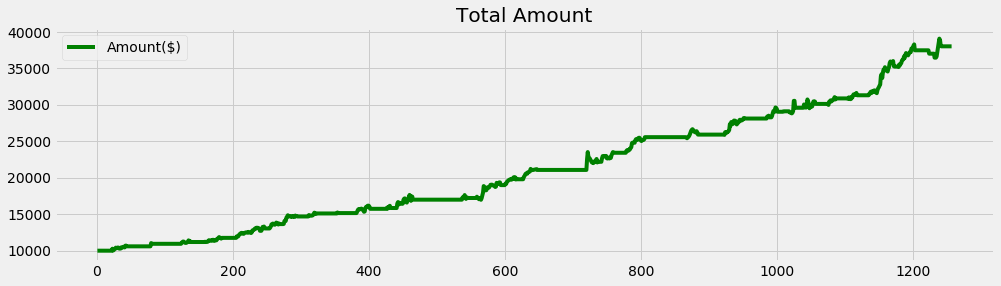

In [79]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [80]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 38016.0 $
Profit_Percent: 380.16 %


* Sharpe Ratio

In [81]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [82]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0010896183072589393 0.007226554916922038


4.465220199974622

# 4. Model evaluaion

* rmse

In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

In [85]:
sqrt(rms)

1.001703052127409